<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3.01 s


### Parallelize with the `dask.delayed` decorator

The two increment calls above can be performed in parallel, because they are independent of one-another.  `dask.delayed` can be used to parallelize custom algorithms like `inc` and `add`. Passing a function like `inc` to `dask.delayed` returns a 'Delayed' object. 

In [3]:
from dask import delayed

In [4]:
inc_delayed = delayed(inc)
add_delayed = delayed(add)
inc_delayed

Delayed('inc-b98fa312-786f-4aa2-9f6a-fbd985ed7fec')

It is very efficient to call the new set of delayed functions because the original functions are not yet called.  Instead, calling delayed functions returns a task graph (directed acrylic graphs or DAGs) showing the order of operations (lazy execution).  

In [5]:
%%time
# This runs immediately, all it does is build a graph
x = inc_delayed(1)
y = inc_delayed(2)
z = add_delayed(x, y)

Wall time: 0 ns


We can show the DAG using `visualize`.  

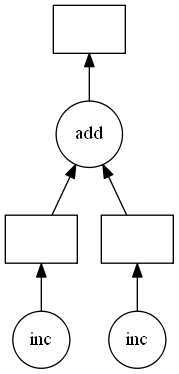

In [6]:
z.visualize()

Notice that the DAG includes the names of the functions defined above, with the results of each `inc` function call passed as input parameters to `add`.

### Some questions to consider:

-  Why did the execution time decrease from 3s to 2s after parallelizing the original functions using dask.delayed?  Why weren't we able to reduce the computation time to 1s by parallelizing the code?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops represent a common operation that can be parallelized.  Below, use `dask.delayed` on `inc` and `sum` to parallelize the computation:

In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

In [ ]:
total

In [ ]:
%%time
# Your parallel code goes here...

In [ ]:
%load solutions/01-delayed-loop.py

How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delay`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [ ]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

In [ ]:
%%time
# Your parallel code goes here...
# TODO: parallelize the sequential code above using dask.delayed
# HINT:  You will need to delay some functions, but not all

In [ ]:
%load solutions/01-delayed-control-flow.py

In [ ]:
%time total.compute()

In [ ]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed to parallelize code?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  Is it necessary to delay `sum`? 

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

### Prep data

First, run this code to prep some data, if you have not already done so.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [ ]:
%run prep.py

### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

In [ ]:
# What is the schema?
df.dtypes

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
from dask import compute

In [ ]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

In [ ]:
%%time
# your code here

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [ ]:
%load solutions/01-delayed-groupby.py

In [ ]:
# ensure the results still match
mean

### Some questions to consider:

- How much did your execution speed improve after using `dask.delayed` to parallelize the computations? Is this what you expected?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?